In [1]:
import os
import pandas as pd
import numpy as np
import time
from sklearn.metrics import f1_score
import torch
import torch.utils.data as Data
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
from math import log

In [2]:
X_train_process1=np.load("C:\\Users\\pc\\Desktop\\Bias Detection\\X_train_glove_title.npy")
X_test_process1=np.load("C:\\Users\\pc\\Desktop\\Bias Detection\\X_test_glove_title.npy")
X_valid_process1=np.load("C:\\Users\\pc\\Desktop\\Bias Detection\\X_valid_glove_title.npy")
y_train_process=np.load("C:\\Users\\pc\\Desktop\\Bias Detection\\y_train_glove.npy")
y_test_process=np.load("C:\\Users\\pc\\Desktop\\Bias Detection\\y_test_glove.npy")
y_valid_process=np.load("C:\\Users\\pc\\Desktop\\Bias Detection\\y_valid_glove.npy")

In [3]:
train_loader = Data.DataLoader(
    dataset=Data.TensorDataset(torch.Tensor(X_train_process1),torch.LongTensor(y_train_process)),      
    batch_size=128,      
    shuffle=True,               
    num_workers=0, 
    drop_last=True
)
test_loader = Data.DataLoader(
    dataset=Data.TensorDataset(torch.Tensor(X_test_process1),torch.LongTensor(y_test_process)),      
    batch_size=128,      
    shuffle=True,               
    num_workers=0,  
    drop_last=True
)
val_loader = Data.DataLoader(
    dataset=Data.TensorDataset(torch.Tensor(X_valid_process1),torch.LongTensor(y_valid_process)),      
    batch_size=128,      
    shuffle=True,               
    num_workers=0,
    drop_last=True
)

In [4]:
def ECA(x,gamma=2,b=1):
    N,C,H,W=x.size()
    t=int(abs((log(C,2)+b)/gamma))
    k=t if t%2 else t+1
    
    avg_pool=nn.AdaptiveAvgPool2d(1).cuda()
    conv=nn.Conv1d(1,1,kernel_size=k,padding=int(k/2),bias=False).cuda()
    sigmoid=nn.Sigmoid().cuda()
    
    y=avg_pool(x)
    y=conv(y.squeeze(-1).transpose(-1,-2))
    y=y.transpose(-1,-2).unsqueeze(-1)
    y=sigmoid(y)
    return y

In [5]:
class TextRCNN(nn.Module):
    def __init__(self,vocab_size,embedding_dim,hidden_size,num_labels=5):
        super(TextRCNN,self).__init__()
        self.lstm = nn.LSTM(input_size=embedding_dim,hidden_size=hidden_size,
                            batch_first=True,bidirectional=False)
        self.dropout = nn.Dropout(.3)
        self.linear1 = nn.Linear(embedding_dim+hidden_size, 128)
        self.linear2 = nn.Linear(600, 128)
        self.linear3 = nn.Linear(128, num_labels)
        self.conv1 = nn.Conv1d(in_channels=128,out_channels=600,kernel_size=6)#通过out_channel改变文中的feature map，且out_channel∈[10,50,100,200,400,600,800,1000]
        self.conv2 = nn.Conv1d(in_channels=128,out_channels=600,kernel_size=7)
        self.conv3 = nn.Conv1d(in_channels=128,out_channels=600,kernel_size=8)
        self.conv4 = nn.Conv1d(in_channels=128,out_channels=600,kernel_size=9)
        self.w_omiga = torch.randn(128,hidden_size,1,requires_grad=True).cuda()

    def forward(self, x):#x: [batch,L]
        x_embed = x.cuda()
        last_hidden_state,(c,h) = self.lstm(x_embed) #last_hidden_state: [batch,L,hidden_size * num_bidirectional]
        H = torch.nn.Tanh()(last_hidden_state)
        weights=torch.nn.Softmax(dim=-1)(torch.bmm(H,self.w_omiga).squeeze(-1)).unsqueeze(dim=-1).repeat(1,1,12)  # LSTM+ATTN-Weight
        last_hidden_state=torch.mul(last_hidden_state,weights)
        out = torch.cat((last_hidden_state[:,:,:12],x_embed,last_hidden_state[:,:,12:]),2)#out: [batch,L,embedding_size + hidden_size * num_bidirectional]  
        out = F.tanh(self.linear1(out))
        out = out.permute(dims=[0,2,1]) #out: [batch,embedding_size + hidden_size * num_bidirectional,L]
        out_1 = self.conv1(out)
        out_1 = nn.ReLU()(out_1)
        out_1 = nn.MaxPool1d(kernel_size=495)(out_1)
        out_2 = self.conv1(out)
        out_2 = nn.ReLU()(out_2)
        out_2 = nn.MaxPool1d(kernel_size=494)(out_2)
        out_3 = self.conv1(out)
        out_3 = nn.ReLU()(out_3)
        out_3 = nn.MaxPool1d(kernel_size=493)(out_3)
        out_4 = self.conv1(out)
        out_4 = nn.ReLU()(out_4)
        out_4 = nn.MaxPool1d(kernel_size=492)(out_4)
        out_1 = out_1.unsqueeze(1).cuda()
        out_2 = out_2.unsqueeze(1).cuda()
        out_3 = out_3.unsqueeze(1).cuda()
        out_4 = out_4.unsqueeze(1).cuda()
        out = torch.cat([out_1, out_2, out_3, out_4],dim=1).cuda()
        channel_weights = F.softmax(ECA(out).squeeze().squeeze(),dim=1).unsqueeze(-1).unsqueeze(-1).expand_as(out)
        out = torch.mul(channel_weights,out)
        out = torch.sum(out, dim = 1)
        out = self.linear2(out.squeeze()) #out: [batch,num_labels]
        out = self.linear3(F.tanh(out))
        out = F.softmax(out,dim=1)
        return out

In [6]:
model = TextRCNN(5302,200,12).cuda()

In [7]:
loss_list, counter =[], []
count = 0
running_loss=0
criterion=nn.CrossEntropyLoss()
optimizer=optim.Adam(model.parameters(),lr=0.001,betas=(0.9,0.999),eps=1e-08,weight_decay=0)
total_train = 0
correct_train = 0
train_epoch, train_loss = [], []
train_acc, val_acc = [], []
avg_epoch, avg_train_loss, avg_val_acc = [], [], []
epoch_time=[]

model.train()
for epoch in range(128): 
    running_loss = 0
    total_train = 0
    correct_train = 0
    total_accuracy = 0
    total_val_accuracy = 0
    correct_val = 0
    total_val = 0   
    start1 = time.time()
    for i, data in enumerate(train_loader, 0):
        start = time.time()
        t_image, mask = data[0],torch.max(data[1],1)[1].long()
        t_image=t_image.cuda()
        optimizer.zero_grad()
        outputs = model(t_image) # forward
        ###########################################################################
        outputs=outputs.cuda()
        mask=mask.cuda()
        loss = criterion(outputs, mask.long()) # calculate the loss
        loss.backward() # back propagation
        optimizer.step() # update gradients
        running_loss += loss.item()
        
        # accuracy
        _, predicted = torch.max(outputs.data, 1)
        total_train += mask.nelement()
        correct_train += predicted.eq(mask.data).sum().item()
        train_accuracy = 100 * correct_train / total_train
        total_accuracy += train_accuracy
        if i % 5 == 0:
            end = time.time()
            print('Epoch {}:[{}/{}], Current Loss: {}, Current Training Accuracy: {}, Time: {} ms'.format(epoch+1, i, len(train_loader), loss.item(), train_accuracy, end - start))      
            train_acc.append(train_accuracy)
            train_loss.append(loss.item())
            train_epoch.append(str(epoch+1) + '/' + str(i))

            for j, data1 in enumerate(val_loader, 0):
                t_image1, mask1 = data1[0],data1[1].long()
                outputs1 = model(t_image1)
                mask1_temp=torch.max(mask1.data,1)
                mask1_temp1=mask1_temp[1].cuda()
                _, predicted1 = torch.max(outputs1.data, 1)
                total_val += mask1.nelement()
                correct_val += predicted1.eq(mask1_temp1).sum().item()
                val_accuracy= 100 * correct_val / total_val
                total_val_accuracy += val_accuracy
            val_acc.append(val_accuracy)
    end1 = time.time()
    print('Epoch {}, train Loss: {:.3f} '.format(epoch+1, running_loss/len(train_loader)), "Avg Training Accuracy: {%d %%}" % (total_accuracy/len(train_loader)), "Avg Validation Accuracy: %d %%" % (total_val_accuracy/len(val_loader)), "Epoch Time: {} ms".format(end1 - start1))
    epoch_time.append(end1-start1)
    avg_epoch.append(epoch+1)
    avg_train_loss.append(running_loss/len(train_loader))
    avg_val_acc.append(total_val_accuracy/len(val_loader))
    #print(avg_epoch)
    #print(avg_train_loss)
    #print(avg_val_acc)

C:\Users\pc\.conda\envs\pytorch\lib\site-packages\torch\nn\functional.py:1949: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Epoch 1:[0/16], Current Loss: 1.6075019836425781, Current Training Accuracy: 14.84375, Time: 4.019031047821045 ms
Epoch 1:[5/16], Current Loss: 1.5319551229476929, Current Training Accuracy: 28.90625, Time: 0.13763689994812012 ms
Epoch 1:[10/16], Current Loss: 1.4671714305877686, Current Training Accuracy: 32.95454545454545, Time: 0.1416490077972412 ms
Epoch 1:[15/16], Current Loss: 1.439016342163086, Current Training Accuracy: 39.794921875, Time: 0.14127874374389648 ms
Epoch 1, train Loss: 1.506  Avg Training Accuracy: {31 %} Avg Validation Accuracy: 27 % Epoch Time: 7.617933988571167 ms
Epoch 2:[0/16], Current Loss: 1.3762669563293457, Current Training Accuracy: 58.59375, Time: 0.14133429527282715 ms
Epoch 2:[5/16], Current Loss: 1.349553108215332, Current Training Accuracy: 56.770833333333336, Time: 0.14131569862365723 ms
Epoch 2:[10/16], Current Loss: 1.3180567026138306, Current Training Accuracy: 56.17897727272727, Time: 0.13483953475952148 ms
Epoch 2:[15/16], Current Loss: 1.3769

Epoch 14, train Loss: 1.027  Avg Training Accuracy: {88 %} Avg Validation Accuracy: 61 % Epoch Time: 3.5386321544647217 ms
Epoch 15:[0/16], Current Loss: 1.0033000707626343, Current Training Accuracy: 89.84375, Time: 0.14220237731933594 ms
Epoch 15:[5/16], Current Loss: 1.0193434953689575, Current Training Accuracy: 89.0625, Time: 0.14106488227844238 ms
Epoch 15:[10/16], Current Loss: 1.0275229215621948, Current Training Accuracy: 88.42329545454545, Time: 0.14180731773376465 ms
Epoch 15:[15/16], Current Loss: 1.0091497898101807, Current Training Accuracy: 88.232421875, Time: 0.1415092945098877 ms
Epoch 15, train Loss: 1.020  Avg Training Accuracy: {88 %} Avg Validation Accuracy: 60 % Epoch Time: 3.542747974395752 ms
Epoch 16:[0/16], Current Loss: 1.0059016942977905, Current Training Accuracy: 89.0625, Time: 0.1415872573852539 ms
Epoch 16:[5/16], Current Loss: 0.9870454668998718, Current Training Accuracy: 89.84375, Time: 0.14568567276000977 ms
Epoch 16:[10/16], Current Loss: 0.99183499

Epoch 28:[10/16], Current Loss: 0.9513014554977417, Current Training Accuracy: 97.79829545454545, Time: 0.12944626808166504 ms
Epoch 28:[15/16], Current Loss: 0.9285399913787842, Current Training Accuracy: 97.65625, Time: 0.14265680313110352 ms
Epoch 28, train Loss: 0.928  Avg Training Accuracy: {97 %} Avg Validation Accuracy: 65 % Epoch Time: 3.5816354751586914 ms
Epoch 29:[0/16], Current Loss: 0.9212614893913269, Current Training Accuracy: 98.4375, Time: 0.1414787769317627 ms
Epoch 29:[5/16], Current Loss: 0.9203563332557678, Current Training Accuracy: 98.046875, Time: 0.14145255088806152 ms
Epoch 29:[10/16], Current Loss: 0.9212549924850464, Current Training Accuracy: 97.72727272727273, Time: 0.15076208114624023 ms
Epoch 29:[15/16], Current Loss: 0.928885817527771, Current Training Accuracy: 97.65625, Time: 0.14111995697021484 ms
Epoch 29, train Loss: 0.928  Avg Training Accuracy: {97 %} Avg Validation Accuracy: 65 % Epoch Time: 3.566263437271118 ms
Epoch 30:[0/16], Current Loss: 0.

Epoch 42:[5/16], Current Loss: 0.9509543180465698, Current Training Accuracy: 98.17708333333333, Time: 0.14353656768798828 ms
Epoch 42:[10/16], Current Loss: 0.928616464138031, Current Training Accuracy: 97.79829545454545, Time: 0.12857627868652344 ms
Epoch 42:[15/16], Current Loss: 0.9124367833137512, Current Training Accuracy: 97.705078125, Time: 0.14521503448486328 ms
Epoch 42, train Loss: 0.928  Avg Training Accuracy: {98 %} Avg Validation Accuracy: 66 % Epoch Time: 3.6025636196136475 ms
Epoch 43:[0/16], Current Loss: 0.9129838943481445, Current Training Accuracy: 99.21875, Time: 0.14175152778625488 ms
Epoch 43:[5/16], Current Loss: 0.9213383197784424, Current Training Accuracy: 97.91666666666667, Time: 0.13064885139465332 ms
Epoch 43:[10/16], Current Loss: 0.9435888528823853, Current Training Accuracy: 97.58522727272727, Time: 0.14136576652526855 ms
Epoch 43:[15/16], Current Loss: 0.9197825789451599, Current Training Accuracy: 97.75390625, Time: 0.14076495170593262 ms
Epoch 43, tr

Epoch 55, train Loss: 0.927  Avg Training Accuracy: {97 %} Avg Validation Accuracy: 65 % Epoch Time: 3.5564768314361572 ms
Epoch 56:[0/16], Current Loss: 0.9050432443618774, Current Training Accuracy: 100.0, Time: 0.14526987075805664 ms
Epoch 56:[5/16], Current Loss: 0.9503771662712097, Current Training Accuracy: 97.52604166666667, Time: 0.13290047645568848 ms
Epoch 56:[10/16], Current Loss: 0.9206733703613281, Current Training Accuracy: 97.44318181818181, Time: 0.13190460205078125 ms
Epoch 56:[15/16], Current Loss: 0.9362900257110596, Current Training Accuracy: 97.802734375, Time: 0.1416466236114502 ms
Epoch 56, train Loss: 0.927  Avg Training Accuracy: {97 %} Avg Validation Accuracy: 66 % Epoch Time: 3.5621700286865234 ms
Epoch 57:[0/16], Current Loss: 0.9203278422355652, Current Training Accuracy: 98.4375, Time: 0.14459753036499023 ms
Epoch 57:[5/16], Current Loss: 0.9513049721717834, Current Training Accuracy: 98.17708333333333, Time: 0.15574049949645996 ms
Epoch 57:[10/16], Curren

Epoch 69:[10/16], Current Loss: 0.9358502626419067, Current Training Accuracy: 97.9403409090909, Time: 0.14504694938659668 ms
Epoch 69:[15/16], Current Loss: 0.9205892086029053, Current Training Accuracy: 98.046875, Time: 0.1410083770751953 ms
Epoch 69, train Loss: 0.924  Avg Training Accuracy: {97 %} Avg Validation Accuracy: 66 % Epoch Time: 3.5685837268829346 ms
Epoch 70:[0/16], Current Loss: 0.9281234741210938, Current Training Accuracy: 97.65625, Time: 0.12726926803588867 ms
Epoch 70:[5/16], Current Loss: 0.9281975030899048, Current Training Accuracy: 97.91666666666667, Time: 0.13766026496887207 ms
Epoch 70:[10/16], Current Loss: 0.9346131682395935, Current Training Accuracy: 97.72727272727273, Time: 0.12709879875183105 ms
Epoch 70:[15/16], Current Loss: 0.9206150770187378, Current Training Accuracy: 98.046875, Time: 0.14168357849121094 ms
Epoch 70, train Loss: 0.924  Avg Training Accuracy: {97 %} Avg Validation Accuracy: 66 % Epoch Time: 3.5692951679229736 ms
Epoch 71:[0/16], Curr

Epoch 83:[5/16], Current Loss: 0.9205332398414612, Current Training Accuracy: 97.91666666666667, Time: 0.13185405731201172 ms
Epoch 83:[10/16], Current Loss: 0.9277511835098267, Current Training Accuracy: 98.01136363636364, Time: 0.14235854148864746 ms
Epoch 83:[15/16], Current Loss: 0.951785683631897, Current Training Accuracy: 98.095703125, Time: 0.14075684547424316 ms
Epoch 83, train Loss: 0.924  Avg Training Accuracy: {98 %} Avg Validation Accuracy: 66 % Epoch Time: 3.566251754760742 ms
Epoch 84:[0/16], Current Loss: 0.9049168825149536, Current Training Accuracy: 100.0, Time: 0.12947821617126465 ms
Epoch 84:[5/16], Current Loss: 0.935030460357666, Current Training Accuracy: 97.65625, Time: 0.13989686965942383 ms
Epoch 84:[10/16], Current Loss: 0.9049116373062134, Current Training Accuracy: 97.9403409090909, Time: 0.14136576652526855 ms
Epoch 84:[15/16], Current Loss: 0.9049314260482788, Current Training Accuracy: 98.095703125, Time: 0.1384742259979248 ms
Epoch 84, train Loss: 0.924

Epoch 96, train Loss: 0.924  Avg Training Accuracy: {98 %} Avg Validation Accuracy: 67 % Epoch Time: 3.710014581680298 ms
Epoch 97:[0/16], Current Loss: 0.9283245205879211, Current Training Accuracy: 97.65625, Time: 0.14400219917297363 ms
Epoch 97:[5/16], Current Loss: 0.9198125004768372, Current Training Accuracy: 97.65625, Time: 0.14101791381835938 ms
Epoch 97:[10/16], Current Loss: 0.9049016237258911, Current Training Accuracy: 97.86931818181819, Time: 0.14199542999267578 ms
Epoch 97:[15/16], Current Loss: 0.9120703935623169, Current Training Accuracy: 98.095703125, Time: 0.14201831817626953 ms
Epoch 97, train Loss: 0.924  Avg Training Accuracy: {97 %} Avg Validation Accuracy: 67 % Epoch Time: 3.6629834175109863 ms
Epoch 98:[0/16], Current Loss: 0.9434607625007629, Current Training Accuracy: 96.09375, Time: 0.14002561569213867 ms
Epoch 98:[5/16], Current Loss: 0.9048936367034912, Current Training Accuracy: 98.17708333333333, Time: 0.14500188827514648 ms
Epoch 98:[10/16], Current Los

Epoch 110:[10/16], Current Loss: 0.9361006021499634, Current Training Accuracy: 98.08238636363636, Time: 0.14299750328063965 ms
Epoch 110:[15/16], Current Loss: 0.9287777543067932, Current Training Accuracy: 98.2421875, Time: 0.14099955558776855 ms
Epoch 110, train Loss: 0.923  Avg Training Accuracy: {98 %} Avg Validation Accuracy: 66 % Epoch Time: 3.6559560298919678 ms
Epoch 111:[0/16], Current Loss: 0.904952347278595, Current Training Accuracy: 100.0, Time: 0.1419992446899414 ms
Epoch 111:[5/16], Current Loss: 0.9128885865211487, Current Training Accuracy: 98.828125, Time: 0.14200139045715332 ms
Epoch 111:[10/16], Current Loss: 0.9130404591560364, Current Training Accuracy: 98.29545454545455, Time: 0.14099574089050293 ms
Epoch 111:[15/16], Current Loss: 0.9049871563911438, Current Training Accuracy: 98.2421875, Time: 0.1419994831085205 ms
Epoch 111, train Loss: 0.923  Avg Training Accuracy: {98 %} Avg Validation Accuracy: 65 % Epoch Time: 3.676002264022827 ms
Epoch 112:[0/16], Curren

Epoch 123, train Loss: 0.922  Avg Training Accuracy: {97 %} Avg Validation Accuracy: 66 % Epoch Time: 3.6349995136260986 ms
Epoch 124:[0/16], Current Loss: 0.9126826524734497, Current Training Accuracy: 99.21875, Time: 0.1419985294342041 ms
Epoch 124:[5/16], Current Loss: 0.9588485956192017, Current Training Accuracy: 98.046875, Time: 0.139998197555542 ms
Epoch 124:[10/16], Current Loss: 0.9433807134628296, Current Training Accuracy: 98.29545454545455, Time: 0.14200210571289062 ms
Epoch 124:[15/16], Current Loss: 0.9355253577232361, Current Training Accuracy: 98.33984375, Time: 0.14299964904785156 ms
Epoch 124, train Loss: 0.921  Avg Training Accuracy: {98 %} Avg Validation Accuracy: 67 % Epoch Time: 3.6559994220733643 ms
Epoch 125:[0/16], Current Loss: 0.9204976558685303, Current Training Accuracy: 98.4375, Time: 0.14100027084350586 ms
Epoch 125:[5/16], Current Loss: 0.9126825332641602, Current Training Accuracy: 98.69791666666667, Time: 0.1419992446899414 ms
Epoch 125:[10/16], Curren

In [8]:
model.eval()
pred_correct_num=[]
pred_total_num=[]
pred_result_list=[]
pred_prob_list = []
label_prob_list=[]
label_list=[]
for i, data in enumerate(test_loader, 0):
    t_image, mask = data[0],torch.max(data[1],1)[1].long()
    mask=mask.cuda()
    output_test=model(t_image)
    pred_prob_list.append(output_test)
    label_prob_list.append(data[1])
    label_list.append(mask)
    output=torch.max(output_test,1)[1].long()
    pred_result_list.append(output)
    pred_correct_num.append(output.eq(mask).sum().item())
    pred_total_num.append(output_test.shape[0])
acc_test=sum(pred_correct_num)/sum(pred_total_num)
print("The accuracy of detecting news bias: {}".format(('%.4f%%'%(acc_test*100))))

The accuracy of detecting news bias: 84.1146%


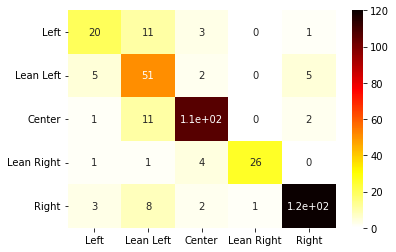

In [9]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
for i in range(len(pred_result_list)):
    if len(pred_result_list) == 1:
        pred_result = pred_result_list[0]
        label = label_list[0]
    if len(pred_result_list) == 2:
        pred_result = torch.cat((pred_result_list[0], pred_result_list[1]), -1)
        label = torch.cat((label_list[0], label_list[1]), -1)
    if len(pred_result_list) > 2:
        pred_result = torch.cat((pred_result_list[0], pred_result_list[1]), -1)
        label = torch.cat((label_list[0], label_list[1]), -1)
    for j in range(len(pred_result_list)-2):
        pred_result = torch.cat((pred_result, pred_result_list[j+2]), -1)
        label = torch.cat((label, label_list[j+2]), -1)
label = label.cpu()
pred_result = pred_result.cpu()
C=confusion_matrix(label,pred_result)
df=pd.DataFrame(C,index=["Left","Lean Left","Center","Lean Right","Right"],columns=["Left","Lean Left","Center","Lean Right","Right"])
p1=sns.heatmap(df,annot=True,cmap="hot_r")
s1 = p1.get_figure()

In [10]:
for i in range(len(pred_prob_list)):
    if len(pred_prob_list) == 1:
        pred_prob = pred_prob_list[0]
        label_prob = label_prob_list[0]
    if len(pred_prob_list) == 2:
        pred_prob = torch.cat((pred_prob_list[0], pred_prob_list[1]), -1)
        label_prob = torch.cat((label_prob_list[0], label_prob_list[1]), -1)
    if len(pred_prob_list) > 2:
        pred_prob = torch.cat((pred_prob_list[0], pred_prob_list[1]), -1)
        label_prob = torch.cat((label_prob_list[0], label_prob_list[1]), -1)
    for j in range(len(pred_prob_list)-2):
        pred_prob = torch.cat((pred_prob, pred_prob_list[j+2]), -1)
        label_prob = torch.cat((label_prob, label_prob_list[j+2]), -1)
label_prob = label_prob.cpu()
pred_prob = pred_prob.cpu()
criterion=nn.L1Loss(reduction="mean")
loss=criterion(pred_prob, label_prob)
print("MAE Value: {}".format("%.4f" % loss))

MAE Value: 0.0662


In [11]:
from sklearn.metrics import f1_score
f1_score = f1_score(pred_result,label,average="macro")
print("Macro-F1 Score: {}".format("%.4f" % f1_score))

Macro-F1 Score: 0.8021
